In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "4"
os.environ["NUM_THREADS"] = "4"
os.environ["OMP_NUM_THREADS"] = "4"
from keras.layers import Input, Dense, Flatten, Reshape
from sklearn.feature_extraction import image as sk_image
from concurrent.futures import ProcessPoolExecutor
import cartopy.feature as cfeature
from keras.models import Model
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sklearn.cluster import AgglomerativeClustering
from scipy.signal import convolve2d 
from scipy import ndimage
from sklearn.cluster import KMeans
import numpy as np
import tensorflow as tf
from tensorflow import keras    
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.cluster import DBSCAN
from pyhdf.SD import SD, SDC
import matplotlib as mpl
#tf.config.threading.set_inter_op_parallelism_threads(1)
from extract_training_data import *
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from pyhdf.error import HDF4Error
from functions import *
from tensorflow.keras.models import load_model
from sklearn.cluster import KMeans, MiniBatchKMeans
import joblib
import plot_functions
import importlib 
importlib.reload(plot_functions)
from plot_functions import *
from sklearn.model_selection import train_test_split
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
# Visualize the result

total cores: 256


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import socket
hostname = socket.gethostname()
if "nird" in hostname:
    tf.config.threading.set_inter_op_parallelism_threads(8)
    data_loc = "/nird/projects/NS9600K/fslippe/data/"
    folder = "/nird/projects/NS9600K/data/modis/cao/MOD02/2020/ /nird/projects/NS9600K/data/modis/cao/MOD02/2021/ /nird/projects/NS9600K/data/modis/cao/MOD02/2023/"
if "mimi" in hostname:
    data_loc = "/uio/hume/student-u37/fslippe/data/"
    folder = "/scratch/fslippe/modis/MOD02/daytime_1km/ /scratch/fslippe/modis/MOD02/boundary_1km/ /scratch/fslippe/modis/MOD02/night_1km/ /scratch/fslippe/modis/MOD02/may-nov_2021/ /scratch/fslippe/modis/MOD02/cao_test_data/"


bands=[1]
max_vals = np.load("%smodels/max_vals_dnb_l95_z50_ps128_(29)_cao_months_202012-202111.npy" %data_loc)


1 Physical GPUs, 1 Logical GPUs


2023-11-29 10:08:43.404452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10074 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [3]:
### EXTRACT CAO AND NOn CAO CASES
import importlib
import extract_training_data
importlib.reload(extract_training_data)
from extract_training_data import *
patch_size = 128


dates_block = np.load("/uio/hume/student-u37/fslippe/data/dates_for_labeling/day_filtered/dates_block.npy")
times_block = np.load("/uio/hume/student-u37/fslippe/data/dates_for_labeling/day_filtered/times_block.npy")
dates_rest = np.load("/uio/hume/student-u37/fslippe/data/dates_for_labeling/day_filtered/dates_rest.npy")
times_rest = np.load("/uio/hume/student-u37/fslippe/data/dates_for_labeling/day_filtered/times_rest.npy")
dates = np.append(dates_block, dates_rest)
times = np.append(times_block, times_rest)

print(dates)
bands = [29]
#folder = "/scratch/fslippe/modis/MOD02/labeling_session"
folder = "/scratch/fslippe/modis/MOD02/2019/ /scratch/fslippe/modis/MOD02/2020/ /scratch/fslippe/modis/MOD02/2021/ /scratch/fslippe/modis/MOD02/2022/ /scratch/fslippe/modis/MOD02/2023/"

#folder = "/scratch/fslippe/modis/MOD02/2020/"
x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = extract_1km_data(folder,
                                                         bands=bands,
                                                         #start_date=start_converted,
                                                         #end_date=end_converted,
                                                         date_list=dates,
                                                         return_lon_lat=True,
                                                         data_loc=data_loc,
                                                         data_type="npy",
                                                         combine_pics=True)

x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao = zip(*[(xi, date, mask, lon_lat, mod_min) for xi, date, mask, lon_lat, mod_min in zip(x_cao, dates_cao, masks_cao, lon_lats_cao, mod_min_cao) if (xi.shape[0] > patch_size) and (xi.shape[1] > patch_size)])
x_cao = list(x_cao)
dates_cao = list(dates_cao)
len(x_cao)

total cores: 256
['2019072' '2019318' '2019286' '2021030' '2019053' '2020081' '2022061'
 '2019018' '2019018' '2020289' '2019060' '2020358' '2022110' '2020024'
 '2019049' '2019027' '2022349' '2019110' '2020023' '2020034' '2022352'
 '2022347' '2019045' '2023022' '2022120' '2022070' '2022095' '2021003'
 '2023080' '2020328' '2022100' '2023040' '2019094' '2019065' '2021362'
 '2020040' '2022278' '2022027' '2020064' '2019080' '2019017' '2022299'
 '2021106' '2023067' '2019001' '2020072' '2020280' '2021307' '2022339'
 '2020344' '2021358' '2023050' '2020338' '2020312' '2021058' '2021332'
 '2019066' '2019024' '2022054' '2023088' '2023083' '2022056' '2020335'
 '2021282' '2021090' '2022337' '2020104' '2020059' '2019005' '2021023'
 '2019117' '2019026' '2020296' '2019041' '2020057' '2019002' '2021275'
 '2021346' '2020103' '2019302' '2022038' '2022102' '2023074' '2020097'
 '2023009' '2022330' '2020115' '2023077' '2019014' '2022068' '2020293'
 '2022040' '2022111' '2020094' '2021097' '2021021' '2020353'

100%|██████████| 157/157 [04:23<00:00,  1.68s/it]


1897
1897


1644

2019049
[1076.7102356  1187.27558899]
(3153, 1076, 1)


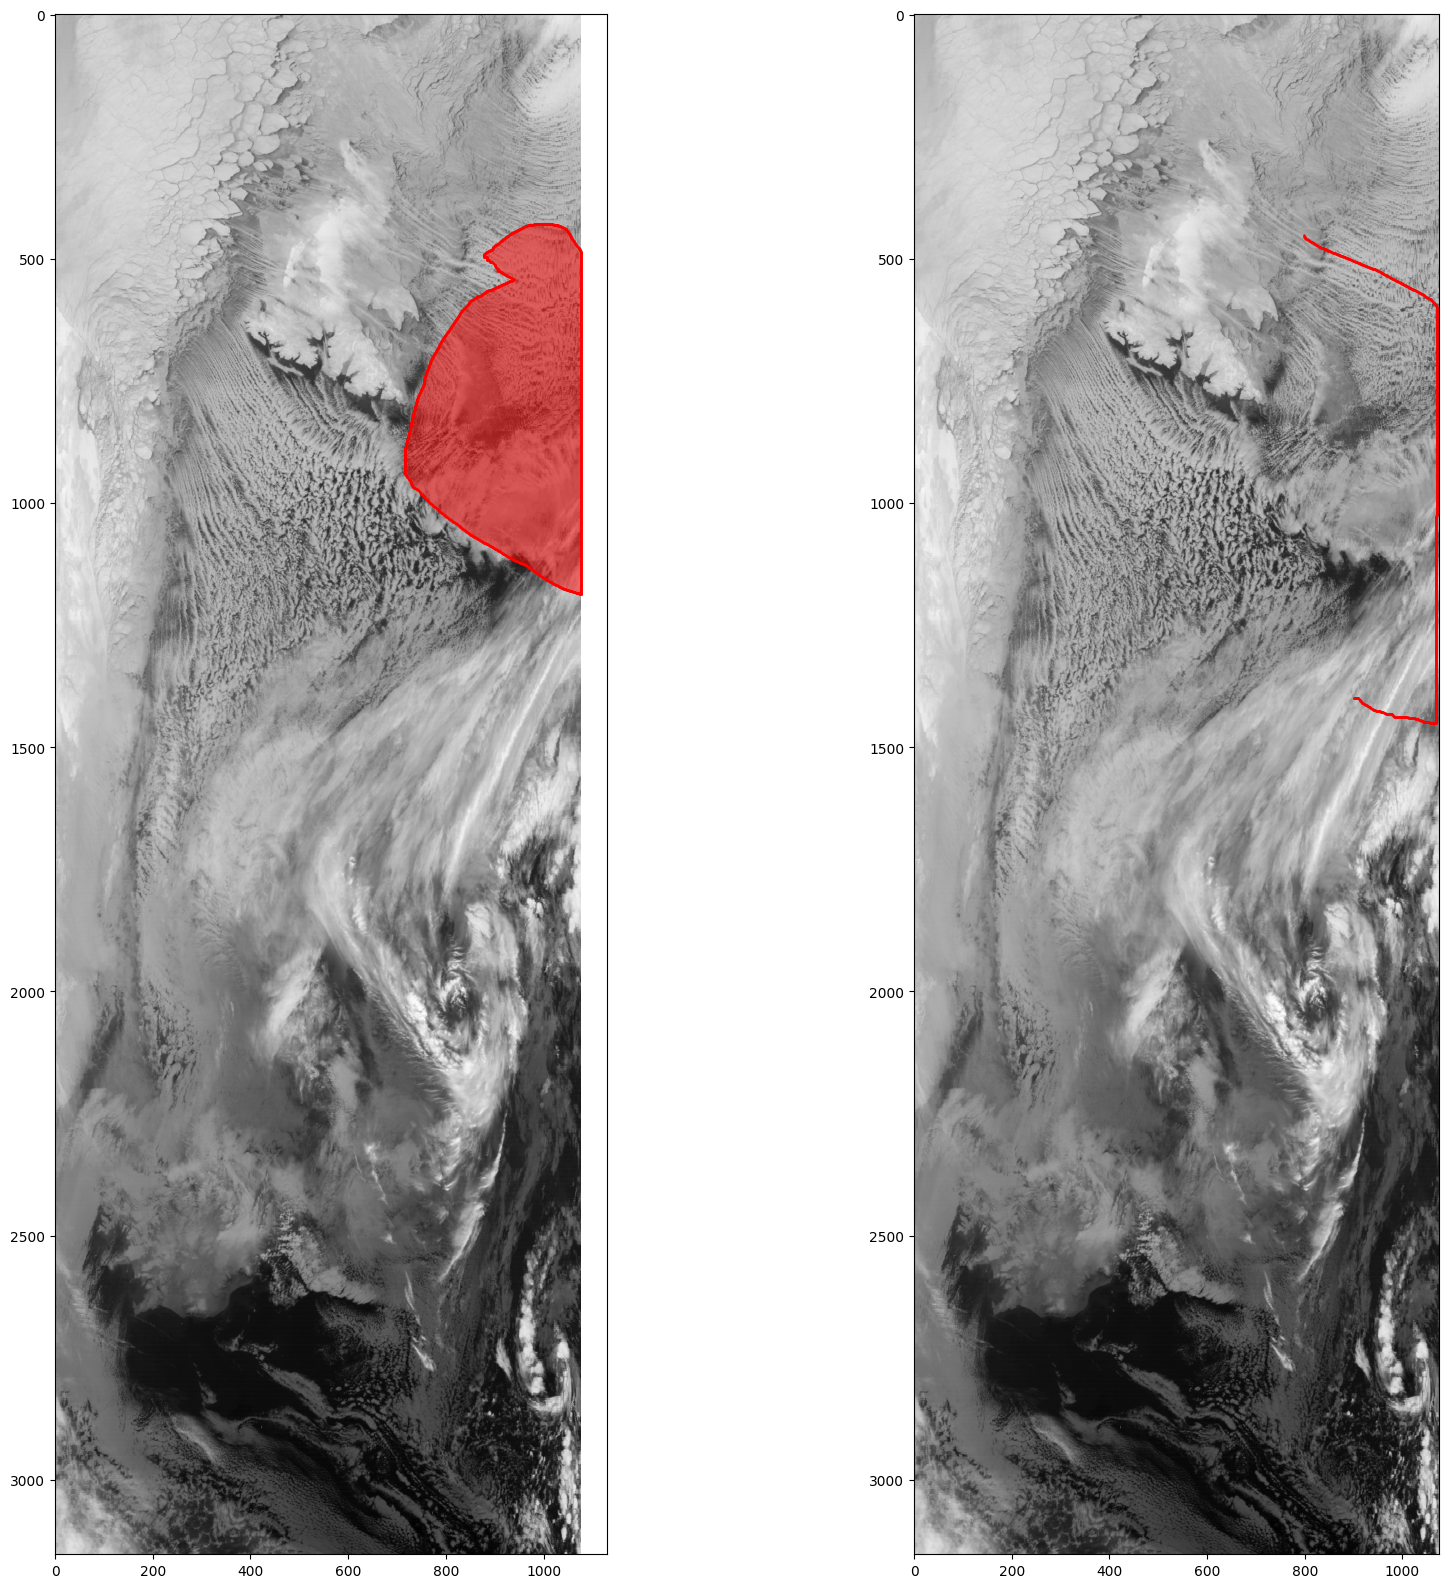

In [16]:
import pandas as pd
import json

# specify the path to the JSON file
filepath = "/uio/hume/student-u37/fslippe/data/figures_for_labeling/results.3"

# load the JSON data into a pandas DataFrame
with open(filepath, "r") as f:
    data = json.load(f)["data"]["image_results"]
df = pd.json_normalize(data)


def bresenham_line(x0, y0, x1, y1):
    """Bresenham's Line Algorithm to generate points between start and end."""
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

def interpolate_coords(coords, connect_first_last):
    """Interpolate between points in coords if they are not neighbors."""
    interpolated = []
    for i in range(len(coords) - 1):
        start = coords[i]
        end = coords[i + 1]
        # Check if points are neighbors
        if max(abs(round(start[0]) - round(end[0])), abs(round(start[1]) - round(end[1]))) > 1:
            interpolated.extend(bresenham_line(
                round((start[0])), round((start[1])), round((end[0])), round((end[1]))))
        else:
            interpolated.append((round(start[0]), round(start[1])))

    interpolated.append(coords[-1])  # Add the last point

    if connect_first_last:
        start = (coords[-1])
        end = (coords[0])
        # Check if points are neighbors
        if max(abs(round(start[0]) - round(end[0])), abs(round(start[1]) - round(end[1]))) > 1:
            interpolated.extend(bresenham_line(
                round((start[0])), round((start[1])), round((end[0])), round((end[1]))))
        else:            
            interpolated.append((round(start[0]), round(start[1])))

    
    return np.array(interpolated)   

for i in range(1):#len(df)):
    i=9
    di = df.iloc[i]
    date_img = str(di["image_id"].split("/")[1].split(".")[1][1:])
    print(date_img)
    time_img = int(di["image_id"].split("/")[1].split(".")[2].split("_")[0])
    area_lines = np.array(di["data.areaLines"])
    border_lines = np.array(di["data.borderLines"], dtype=object)
    interpolated_border = []

    interpolated_area = []
    n_areas = len(area_lines)
    if n_areas > 0:
        for j in range(n_areas):
            area = np.array(area_lines[j])
            print(area.max(axis=0))
            interpolated_area.append(interpolate_coords(area, connect_first_last=True))

    idx = np.where((np.array(dates_cao) == date_img) & (np.array(mod_min_cao) == time_img))[0][0]
    print(x_cao[idx].shape)

    fig, axs = plt.subplots(1,2, figsize=[20, 20])
    axs[0].imshow(x_cao[idx], cmap="gray_r")
    for k in range(len(interpolated_area)):
        axs[0].scatter(interpolated_area[k].T[0], interpolated_area[k].T[1], s=0.5, color="r")
        axs[0].fill(interpolated_area[k].T[0], interpolated_area[k].T[1], alpha=0.5, color="r")


    n_borders = len(border_lines)
    if n_borders >0:
        #print(n_borders)
        for j in range(n_borders):
            border = np.array(border_lines[j])
            interpolated_border.append(interpolate_coords(border, connect_first_last=False))

    idx = np.where((np.array(dates_cao) == date_img) & (np.array(mod_min_cao) == time_img))[0][0]
    axs[1].imshow(x_cao[idx], cmap="gray_r")
    for k in range(len(interpolated_border)):
        axs[1].scatter(interpolated_border[k].T[0], interpolated_border[k].T[1], s=0.5, color="r")
        

In [8]:
np.min(interpolated_area)

-3.0

In [41]:
from PIL import Image

for i in range(len(x_cao)):
    if (dates_cao[i], mod_min_cao[i]) in zip(dates_block, times_block):
        # Scale data to range 0-255 and convert type
        img_data = np.array((x_cao[i][:,:,0] - np.min(x_cao[i])) / (np.max(x_cao[i]) - np.min(x_cao[i])) * 255, dtype=np.uint8)
        
        # Invert the image data
        img_data = 255 - img_data
        
        # Convert numpy array to PIL Image
        image = Image.fromarray(img_data)

        # Save the image
        image.save("/uio/hume/student-u37/fslippe/data/figures_for_labeling/block/MOD021KM.A%s.%s_block.jpg" %(dates_cao[i], mod_min_cao[i]))

for i in range(len(x_cao)):
    if (dates_cao[i], mod_min_cao[i]) in zip(dates_rest, times_rest):
        # Scale data to range 0-255 and convert type
        img_data = np.array((x_cao[i][:,:,0] - np.min(x_cao[i])) / (np.max(x_cao[i]) - np.min(x_cao[i])) * 255, dtype=np.uint8)
        
        # Invert the image data
        img_data = 255 - img_data

        # Convert numpy array to PIL Image
        image = Image.fromarray(img_data)

        # Save the image
        image.save("/uio/hume/student-u37/fslippe/data/figures_for_labeling/rest/MOD021KM.A%s.%s_rest.jpg" %(dates_cao[i], mod_min_cao[i]))


In [22]:
import matplotlib.pyplot as plt

dpi = 80  # change this to match your needs


for i in range(len(x_cao)):
    if (dates_cao[i], mod_min_cao[i]) in zip(dates_block, times_block): 
        height_pixels, width_pixels = x_cao[i].shape[:2]
        height_inches = height_pixels / dpi
        width_inches = width_pixels / dpi
        fig = plt.figure(figsize=(width_inches, height_inches), dpi=dpi)
        plt.imshow(x_cao[i], cmap="gray_r")
        plt.axis('off')  # to hide the axes
        plt.savefig("/uio/hume/student-u37/fslippe/data/figures_for_labeling/MOD021KM.A%s.%s_block.jpg" %(dates_cao[i], mod_min_cao[i]), dpi=dpi, bbox_inches='tight', pad_inches=0)
        plt.close(fig)


(1311, 1076, 1)
(3158, 1076, 1)
(629, 630, 1)
(2659, 1076, 1)
(1371, 1076, 1)
(2957, 1076, 1)
(3243, 1076, 1)
(2897, 1076, 1)
(3153, 1076, 1)
(3062, 1076, 1)
(2762, 1076, 1)
(2813, 1076, 1)
(3174, 1076, 1)
(2998, 1076, 1)
(3042, 1076, 1)
(3042, 1076, 1)
(3042, 1076, 1)
(3037, 1076, 1)
(2878, 1076, 1)
(1792, 640, 1)
(2546, 825, 1)
(2856, 1076, 1)
(2743, 1076, 1)
(3228, 1076, 1)
(3052, 1076, 1)
(3047, 1076, 1)
(3067, 1076, 1)
(1005, 419, 1)
(2561, 940, 1)
(3042, 1076, 1)
(2976, 1076, 1)
(3328, 1068, 1)
(3112, 1076, 1)
(3063, 1076, 1)
(3038, 1076, 1)
(3022, 1076, 1)
(3358, 1053, 1)
(2872, 1076, 1)
(2701, 1076, 1)
(3037, 1076, 1)
(3042, 1076, 1)
(3088, 1076, 1)
(3033, 1076, 1)
(3418, 1033, 1)
(1711, 1076, 1)
(3017, 1076, 1)
(2862, 1076, 1)
(930, 1076, 1)
(2787, 1076, 1)


In [38]:
from PIL import Image

# Generate a saved image for testing (You should replace this as your actual image pathname)
image_path = "/uio/hume/student-u37/fslippe/data/figures_for_labeling/block/MOD021KM.A2019318.1155_block.jpg"

# Open the saved image and get dimensions
with Image.open(image_path) as img:
    width, height = img.size
    print(width, height)

1076 3037


In [13]:
import datetime

# assuming dates and times are lists of strings
for i in range(len(dates)):
    if not (dates[i], times[i]) in zip(dates_cao, mod_min_cao):
        print("%s-%s %02d:%02d" % (dates[i][:4], dates[i][4:], times[i]//100, times[i]%100))
    else:
        print(dates[i])




2019072
2019318
2019286
2021030
2019053
2020081
2022061
2019018
2019018
2020289
2019060
2020358
2022110
2020024
2019049
2019027
2022349
2019110
2020023
2020034
2022352
2022347
2019045
2023022
2022120
2022070
2022095
2021003
2023080
2020328
2022100
2023040
2019094
2019065
2021362
2020040
2022278
2022027
2020064
2019080
2019017
2022299
2021106
2023067
2019001
2020072
2020280
2021307
2022339
2020344
2021358
2023050
2020338
2020312
2021058
2021332
2019066
2019024
2022054
2023088
2023083
2022056
2020335
2021282
2021090
2022337
2020104
2020059
2019005
2021023
2019117
2019026
2020296
2019041
2020057
2019002
2021275
2021346
2020103
2019302
2022038
2022102
2023074
2020097
2023009
2022330
2020115
2023077
2019014
2022068
2020293
2022040
2022111
2020094
2021097
2021021
2020353
2022109
2022319
2021355
2021328
2023009
2021343
2021353
2020024
2021028
2022116
2021359
2021355
2020113
2021058
2020327
2022318
2022088
2022101
2023027
2020305
2023080
2019063
2021294
2020095
2023064
2022017
2022323
2022057
